# Leveraging data analytics and machine learning to improve customer satisfaction
--- 

Jose Oliveira da Cruz | jose [at] jfocruz [dot] com




## Index of Jupyter Notebook: `nb02_modeling-part1.ipynb`
---
- [Background](#background)
- [Load data](#load)
- [Modeling](#model)


## Background

EDA shows that the variables `replytime` and `fullresolutiontime` are substantially different across Good and Bad CSAT scores. 
- Can we use a combination of variables to predict missing CSAT scores? If so, what variables and decision processes are the most appropriate to use?


In [1]:
# Load libraries
import os
import datetime
import missingno as msno # to visualize missing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set random state
np.random.seed(42)


save_figs = True
plt.style.use('ggplot')
fig_kwargs = dict(bbox_inches='tight')

<a id="load"><a/>

## Load data
---

In [2]:
df_tickets_with_satisfaction = pd.read_csv('../data/processed/merged_datasets.csv', index_col=0)

<AxesSubplot:>

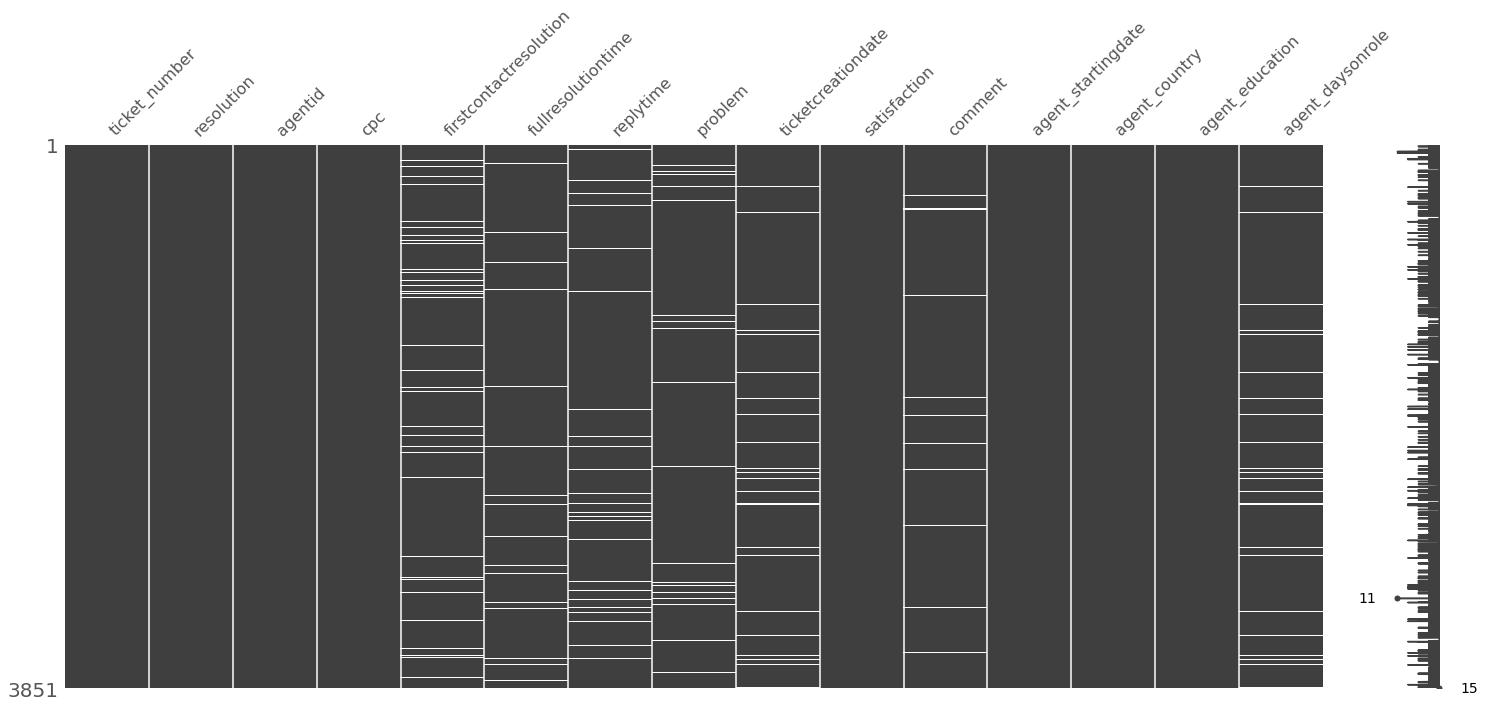

In [3]:
# Dataframe after removing missing agentid and duplicated tickets
msno.matrix(df_tickets_with_satisfaction)

In [4]:
df_tickets_with_satisfaction.head(2)

,ticket_number,resolution,agentid,cpc,firstcontactresolution,fullresolutiontime,replytime,problem,ticketcreationdate,satisfaction,comment,agent_startingdate,agent_country,agent_education,agent_daysonrole
0,13371,1.0,1412.0,3.0,0.0,7.0,239.0,Payment processing,NaN,Good,eficient player mode,2019-10-08,Brazil,Law,NaN
1,12480,1.0,1921.0,4.0,0.0,3.0,284.0,Item do not show,2021-05-27,Good,eficient item,2015-04-10,Brazil,Humanities,2239.0


<a id="model"><a/>
## Modeling

In [5]:
# sklearn packages
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.pipeline import make_pipeline

### Data Preparation

In [6]:
# Subset features based on KPI analysis
numeric_features = ['fullresolutiontime', 'replytime', 'cpc',]

In [7]:
# subset the data
data = df_tickets_with_satisfaction[numeric_features]
target = df_tickets_with_satisfaction['satisfaction']

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target)

### Select Best Params with GridSearchCV

In [8]:
# Prepare grid to find the best params
grid_params = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [2],
}

# Create a model pipeline
model_pipeline = make_pipeline(SimpleImputer(strategy='median'), # impute missing numerical data
                               DecisionTreeClassifier())


# Prepare the gridsearch object
model = GridSearchCV(model_pipeline,
                     param_grid=grid_params,
                     scoring='accuracy',
                     n_jobs=-1,
                     cv=10,
                     return_train_score=True)

In [9]:
model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [2]},
             return_train_score=True, scoring='accuracy')

### Evaluate the generalization of the model with cross-validation

In [10]:
cv_scores = cross_validate(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

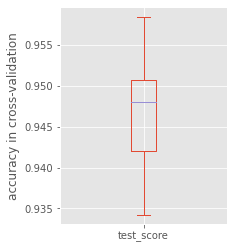

In [11]:
fig, ax = plt.subplots()

# plot scores
pd.DataFrame(cv_scores)['test_score'].plot(kind='box', figsize=(3, 4), ax=ax)

ax.set(ylabel='accuracy in cross-validation')

plt.show()

### Evaluate the model on unseen data

In [12]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'The performance on train dataset is: {train_score: 0.2f}')
print(f'The performance on test dataset is: {test_score: 0.2f}')

The performance on train dataset is:  0.95
The performance on test dataset is:  0.95


### Visualize the decision process

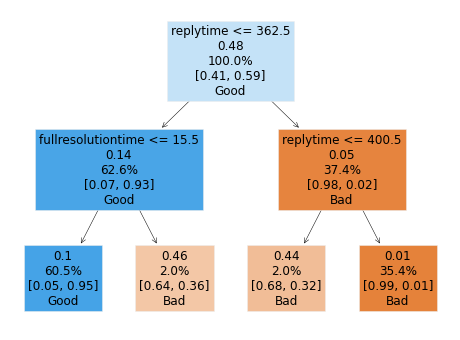

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_tree(model.best_estimator_['decisiontreeclassifier'], 
          class_names=model.classes_, 
          feature_names=data.columns, precision=2, fontsize=12, proportion=True, filled=True, label='none', ax=ax)

if save_figs:
    plt.savefig(r'../reports/figures/decision_tree.jpeg', **fig_kwargs)

### Make Predictions of Customer data without CSAT Score and Apply visualizations to predicted data

In [14]:
data = pd.read_csv('../data/interim/tickets_withoutCSAT_preprocessed.csv', index_col=0)

In [15]:
new_labels = model.predict(data[numeric_features])

In [16]:
data['satisfaction'] = new_labels

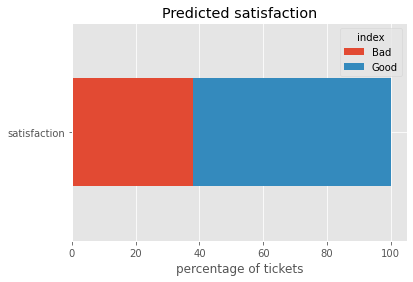

In [17]:
predicted_satisfaction = data.satisfaction.value_counts(normalize=True).iloc[:2].round(2) * 100

fig, ax = plt.subplots()

predicted_satisfaction.reset_index()\
                      .pivot_table(values='satisfaction', columns='index')\
                      .plot(kind='barh', stacked=True, ax=ax)

ax.set(xlabel='percentage of tickets', title='Predicted satisfaction')
ax.tick_params('y', rotation=0)
# plt.legend(loc=(1, .35))

if save_figs:
    plt.savefig(r'../reports/figures/predicted_csat_proportion.jpeg', **fig_kwargs)

In [18]:
predicted_satisfaction

Good    62.0
Bad     38.0
Name: satisfaction, dtype: float64

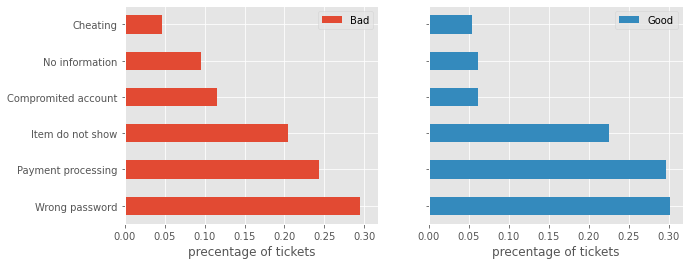

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)

colors = {'Bad': '#E24A33', 'Good': '#348ABD'}


for idx, rating in enumerate(data.satisfaction.unique()):

    data[data.satisfaction.isin([rating])].problem\
                                                             .value_counts(dropna=False, normalize=True)\
                                                             .rename(index={np.nan: 'No information'})\
                                                             .plot(kind='barh', ax=ax[idx], color=colors.get(rating), label=f'{rating}')

    ax[idx].set(xlabel='precentage of tickets')
    ax[idx].legend()

---
2022 - Jose Oliveira da Cruz